# Pymaceuticals Inc.
---

### Analysis

- Add your analysis here.
 

## Background
<h4>
You've just joined Pymaceuticals, Inc., a new pharmaceutical company that specializes in anti-cancer medications.  
Recently, it began screening for potential treatments for squamous cell carcinoma (SCC), a commonly occurring form of skin cancer.  

As a senior data analyst at the company, you've been given access to the complete data from their most recent  
animal study. In this study, 249 mice who were identified with SCC tumors received treatment with a range of drug regimens.  
Over the course of 45 days, tumor development was observed and measured. The purpose of this study was to compare the  
performance of Pymaceuticals’ drug of interest, Capomulin, against the other treatment regimens.  

The executive team has tasked you with generating all of the tables and figures needed for the technical report of the  
clinical study. They have also asked you for a top-level summary of the study results.  </h4>

## Instructions

### This assignment is broken down into the following tasks:  
#### Prepare the data.  
#### |-+-| Generate summary statistics.  
#### |-+-| Create bar charts and pie charts.  
#### |-+-| Calculate quartiles, find outliers, and create a box plot.  
#### |-+-| Create a line plot and a scatter plot.  
#### |-+-| Calculate correlation and regression.  
#### |-+-| Submit your final analysis.  

In [1]:
# LIBRARY AND SETUP:

# Import dependencies
import pandas as pd
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st

# Path assignments
mouseData_path = Path('data/Mouse_metadata.csv')
studyData_path = Path('data/Study_results.csv')

# Read-in CSV's and convert to DataFrame objects
mouseData_df = pd.read_csv(mouseData_path)
studyData_df = pd.read_csv(studyData_path)

# Merge DataFrames and preview
mergeData_df = pd.merge(mouseData_df, studyData_df, how = 'outer', on = 'Mouse ID')
mergeData_df.head(10)

,Mouse ID,Drug Regimen,Sex,Age_months,Weight (g),Timepoint,Tumor Volume (mm3),Metastatic Sites
0,a203,Infubinol,Female,20,23,0,45.000000,0
1,a203,Infubinol,Female,20,23,5,48.508468,0
2,a203,Infubinol,Female,20,23,10,51.852437,1
3,a203,Infubinol,Female,20,23,15,52.777870,1
4,a203,Infubinol,Female,20,23,20,55.173336,1
5,a203,Infubinol,Female,20,23,25,56.793208,1
6,a203,Infubinol,Female,20,23,30,59.523197,1
7,a203,Infubinol,Female,20,23,35,61.931650,2
8,a203,Infubinol,Female,20,23,40,63.593490,2
9,a203,Infubinol,Female,20,23,45,67.973419,2


In [2]:
del mouseData_df
del studyData_df

In [3]:
# DATAFRAME CHECKING AND CLEANUP:

# Column Re-organization and Rename
mergeData_df = mergeData_df.rename(columns = {
    'Age_months': 'Age (Months)'
    })[
    ['Mouse ID', 'Timepoint', 'Tumor Volume (mm3)', 'Metastatic Sites', 
    'Drug Regimen', 'Sex', 'Age (Months)', 'Weight (g)']
    ]

# Check # of mice in df (unique Mouse ID's)
mouseID_list = mergeData_df['Mouse ID'].unique()
print(len(mouseID_list))

249


In [4]:
# Data entries will be uniquely identified by Mouse ID and Timepoint
# Get the duplicate mice by ID number that shows up for Mouse ID and Timepoint.

# Find Mice ID's with duplicate rows for Timepoint
duplicates = []

for mouse in mouseID_list:
    mouse_select = mergeData_df.loc[mergeData_df['Mouse ID'] == mouse, :]
    timepoint_counts = mouse_select['Timepoint'].value_counts()

    for time in timepoint_counts:
        if time > 1:
            duplicates.append(mouse)
            break

print(duplicates)

['g989']


In [5]:
del timepoint_counts, mouse_select

In [6]:
# Optional: Get all the data for the duplicate mouse ID.

# Display all data associated with each duplicate mouse ID
for duplicate in duplicates:
    display(mergeData_df.loc[mergeData_df['Mouse ID'] == duplicate, :])

# Also achievable using df.isin(__list) method:
# display(mergeData_df.loc[mergeData_df['Mouse ID'].isin(duplicates), :])

,Mouse ID,Timepoint,Tumor Volume (mm3),Metastatic Sites,Drug Regimen,Sex,Age (Months),Weight (g)
586,g989,0,45.000000,0,Propriva,Female,21,26
587,g989,0,45.000000,0,Propriva,Female,21,26
588,g989,5,48.786801,0,Propriva,Female,21,26
589,g989,5,47.570392,0,Propriva,Female,21,26
590,g989,10,51.745156,0,Propriva,Female,21,26
591,g989,10,49.880528,0,Propriva,Female,21,26
592,g989,15,51.325852,1,Propriva,Female,21,26
593,g989,15,53.442020,0,Propriva,Female,21,26
594,g989,20,55.326122,1,Propriva,Female,21,26
595,g989,20,54.657650,1,Propriva,Female,21,26


In [7]:
# Cleaned merged df (duplicates dropped):
# Copy merged df - drop indeces of duplicate mice
clean_df = mergeData_df.copy()
df_indeces = clean_df.loc[clean_df['Mouse ID'].isin(duplicates), :].index
clean_df = clean_df.drop(df_indeces, axis = 0)


In [8]:
del mergeData_df, df_indeces, duplicates

In [9]:
# Checking # of mice in newly cleaned df
print(len(clean_df['Mouse ID'].unique()))

248


## Summary Statistics

In [10]:
# Generate a summary statistics table of mean, median, variance, standard deviation, and SEM of the tumor volume for each regimen

# Use groupby and summary statistical methods to calculate the following properties of each drug regimen:
# mean, median, variance, standard deviation, and SEM of the tumor volume.
# Assemble the resulting series into a single summary DataFrame.

tumor_byDrug = clean_df.groupby('Drug Regimen')['Tumor Volume (mm3)']

clean_df_summary = pd.DataFrame(
    {
        'Mean Tumor Volume': tumor_byDrug.mean(), 
        'Median Tumor Volume': tumor_byDrug.median(), 
        'Tumor Volume Variance': tumor_byDrug.var(), 
        'Tumor Volume Std. Dev.': tumor_byDrug.std(),
        'Tumor Volume Std. Err.': tumor_byDrug.sem()
    }
)

clean_df_summary

,Mean Tumor Volume,Median Tumor Volume,Tumor Volume Variance,Tumor Volume Std. Dev.,Tumor Volume Std. Err.
Drug Regimen,,,,,
Capomulin,40.675741,41.557809,24.947764,4.994774,0.329346
Ceftamin,52.591172,51.776157,39.290177,6.268188,0.469821
Infubinol,52.884795,51.820584,43.128684,6.567243,0.492236
Ketapril,55.235638,53.698743,68.553577,8.279709,0.603860
Naftisol,54.331565,52.509285,66.173479,8.134708,0.596466
Placebo,54.033581,52.288934,61.168083,7.821003,0.581331
Propriva,52.320930,50.446266,43.852013,6.622085,0.544332
Ramicane,40.216745,40.673236,23.486704,4.846308,0.320955
Stelasyn,54.233149,52.431737,59.450562,7.710419,0.573111


In [11]:
# A more advanced method to generate a summary statistics table of mean, median, variance, standard deviation,
# and SEM of the tumor volume for each regimen (only one method is required in the solution)

# Using the aggregation method, produce the same summary statistics in a single line

tumor_byDrug.aggregate(['mean', 'median', 'var', 'std', 'sem'])


,mean,median,var,std,sem
Drug Regimen,,,,,
Capomulin,40.675741,41.557809,24.947764,4.994774,0.329346
Ceftamin,52.591172,51.776157,39.290177,6.268188,0.469821
Infubinol,52.884795,51.820584,43.128684,6.567243,0.492236
Ketapril,55.235638,53.698743,68.553577,8.279709,0.603860
Naftisol,54.331565,52.509285,66.173479,8.134708,0.596466
Placebo,54.033581,52.288934,61.168083,7.821003,0.581331
Propriva,52.320930,50.446266,43.852013,6.622085,0.544332
Ramicane,40.216745,40.673236,23.486704,4.846308,0.320955
Stelasyn,54.233149,52.431737,59.450562,7.710419,0.573111


## Bar and Pie Charts

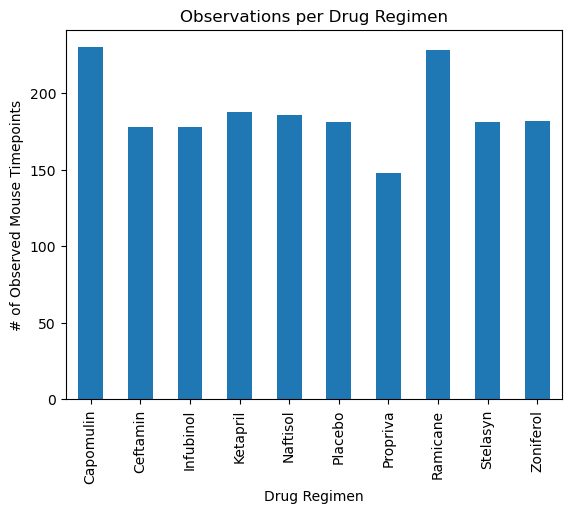

In [12]:
# Generate a bar plot showing the total number of rows (Mouse ID/Timepoints) for each drug regimen using Pandas.
mouse_byDrug = clean_df.groupby('Drug Regimen')['Timepoint'].count()

mouse_byDrug.plot(kind = 'bar')
plt.ylabel('# of Observed Mouse Timepoints')
plt.title('Observations per Drug Regimen')
plt.show()

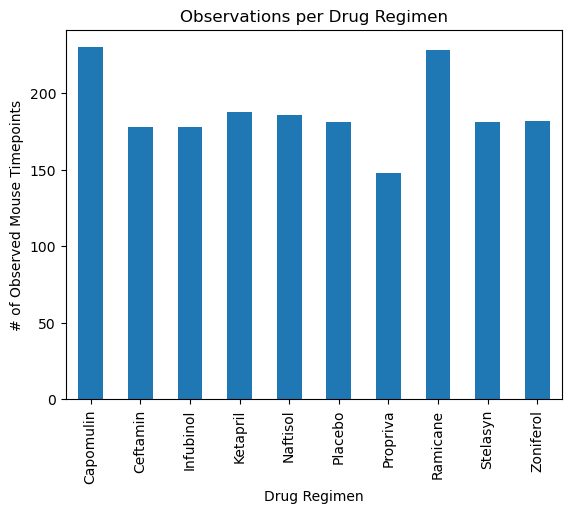

In [13]:
# Generate a bar plot showing the total number of rows (Mouse ID/Timepoints) for each drug regimen using pyplot.
xAxis = np.arange(len(mouse_byDrug))
plt.bar(xAxis, mouse_byDrug, align = 'center', width = 0.5)
plt.xticks(xAxis, mouse_byDrug.index, rotation = 90)
plt.xlabel('Drug Regimen')
plt.xlim((xAxis[0] - 0.5), (xAxis[-1] + 0.5))
plt.ylabel('# of Observed Mouse Timepoints')
plt.title('Observations per Drug Regimen')
plt.show()

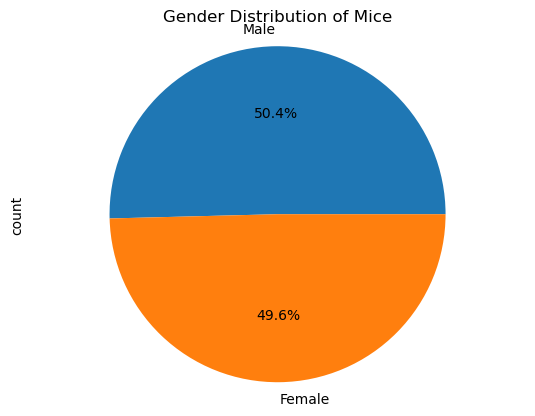

In [14]:
# Generate a pie chart, using Pandas, showing the distribution of unique female versus male mice used in the study
# Get the unique mice with their gender
mouse_byGender = clean_df.copy()
mouse_byGender = mouse_byGender.drop_duplicates('Mouse ID').set_index('Mouse ID')['Sex']

# Make the pie chart
mouse_byGender.value_counts().plot(kind = 'pie', title = 'Gender Distribution of Mice', autopct = '%1.1f%%')
plt.axis('equal')
plt.show()

In [15]:
del xAxis

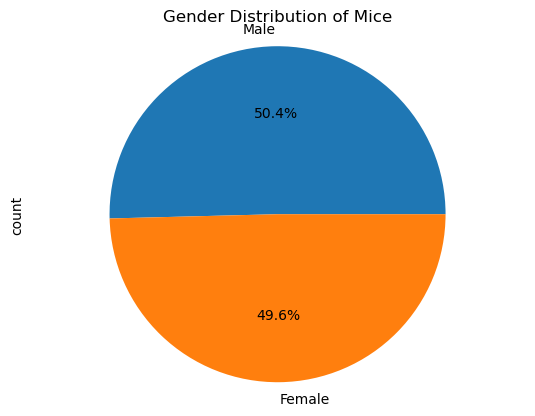

In [16]:
# Generate a pie chart, using pyplot, showing the distribution of unique female versus male mice used in the study

# Get the unique mice with their gender
# Using mouse_byGender again (Unique MouseID by Sex)

# Make the pie chart
plt.pie(mouse_byGender.value_counts(), labels = mouse_byGender.value_counts().index, autopct = '%1.1f%%')
plt.ylabel('count')
plt.title('Gender Distribution of Mice')
plt.axis('equal')
plt.show()

## Quartiles, Outliers and Boxplots

In [17]:
# Calculate the final tumor volume of each mouse across four of the treatment regimens:
# Capomulin, Ramicane, Infubinol, and Ceftamin

# Start by getting the last (greatest) timepoint for each mouse
timepoint_max = clean_df.groupby('Mouse ID')[['Timepoint']].max().reset_index()

# Merge this group df with the original DataFrame to get the tumor volume at the last timepoint
tumor_df = pd.merge(clean_df, timepoint_max, how = 'inner', on = ['Mouse ID', 'Timepoint'])
tumor_df

,Mouse ID,Timepoint,Tumor Volume (mm3),Metastatic Sites,Drug Regimen,Sex,Age (Months),Weight (g)
0,a203,45,67.973419,2,Infubinol,Female,20,23
1,a251,45,65.525743,1,Infubinol,Female,21,25
2,a262,45,70.717621,4,Placebo,Female,17,29
3,a275,45,62.999356,3,Ceftamin,Female,20,28
4,a366,30,63.440686,1,Stelasyn,Female,16,29
...,...,...,...,...,...,...,...,...
243,z435,10,48.710661,0,Propriva,Female,12,26
244,z578,45,30.638696,0,Ramicane,Male,11,16
245,z581,45,62.754451,3,Infubinol,Female,24,25
246,z795,45,65.741070,3,Naftisol,Female,13,29


In [32]:
# Put treatments into a list for a 'for' loop (and later for plot labels)
drugs = ['Capomulin', 'Ramicane', 'Infubinol', 'Ceftamin']

# Create empty list to fill with tumor vol data (for plotting)
tumors = []

# Calculate the IQR and quantitatively determine if there are any potential outliers.
# ???????????? 
# <- ASK IN OFFICE HOURS
# quarts = tumor_df['Tumor Volume (mm3)'].quantile([0.25, 0.5, 0.75])
# upperQ = quarts[0.75]
# lowerQ = quarts[0.25]

# iqr = upperQ - lowerQ
# upperLim = upperQ + (1.5 * iqr)
# lowerLim = lowerQ - (1.5 * iqr)

# display(tumor_df[['Tumor Volume (mm3)']].describe())
# ???????????? ->

    # Locate the rows which contain mice on each drug and get the tumor volumes
for drug in drugs:
    drug_select = tumor_df.loc[(tumor_df['Drug Regimen'] == drug), 'Tumor Volume (mm3)']
    quarts = drug_select.quantile([0.25, 0.5, 0.75])
    upperQ = quarts[0.75]
    lowerQ = quarts[0.25]

    iqr = upperQ - lowerQ
    upperLim = upperQ + (1.5 * iqr)
    lowerLim = lowerQ - (1.5 * iqr)

    # add subset
    tumors.append(drug_select)

    # Determine outliers using upper and lower bounds
    pot_outlier = drug_select.loc[((drug_select > upperLim) | (drug_select < lowerLim))]
    print(f"{drug}'s potential outliers: {pot_outlier}")

Capomulin's potential outliers: Series([], Name: Tumor Volume (mm3), dtype: float64)
Ramicane's potential outliers: Series([], Name: Tumor Volume (mm3), dtype: float64)
Infubinol's potential outliers: 31    36.321346
Name: Tumor Volume (mm3), dtype: float64
Ceftamin's potential outliers: Series([], Name: Tumor Volume (mm3), dtype: float64)


In [48]:
# Generate a box plot that shows the distribution of the tumor volume for each treatment group.
# main_figure, axes = plt.subplots()

NEWDF = [pd.DataFrame(tumor) for tumor in tumors]
[display(df) for df in NEWDF]

# for drug in drugs:
#     mouse_select = tumor_df.loc[(tumor_df['Drug Regimen'] == drug), 'Tumor Volume (mm3)']
#     axes.boxplot(mouse_select, positions = )


,Tumor Volume (mm3)
19,38.982878
24,38.939633
61,30.485985
64,37.074024
66,40.159220
80,47.685963
83,37.311846
85,38.125164
87,38.753265
108,41.483008


,Tumor Volume (mm3)
6,38.407618
7,43.047543
10,38.810366
12,32.978522
33,38.342008
37,33.397653
45,37.311236
52,40.659006
70,29.128472
76,33.562402


,Tumor Volume (mm3)
0,67.973419
1,65.525743
11,57.031862
13,66.083066
27,72.226731
31,36.321346
41,60.969711
50,62.435404
56,60.918767
78,67.289621


,Tumor Volume (mm3)
3,62.999356
21,45.000000
22,56.057749
25,55.742829
58,48.722078
75,47.784682
88,61.849023
94,68.923185
106,67.748662
107,57.918381


[None, None, None, None]

## Line and Scatter Plots

In [ ]:
# Generate a line plot of tumor volume vs. time point for a single mouse treated with Capomulin


In [ ]:
# Generate a scatter plot of mouse weight vs. the average observed tumor volume for the entire Capomulin regimen


## Correlation and Regression

In [ ]:
# Calculate the correlation coefficient and a linear regression model
# for mouse weight and average observed tumor volume for the entire Capomulin regimen
